# Exercise 1.2
## This *.ipynb file contains:



In [27]:
import numpy as np
import torch
from Exercise1_1 import LQRSolver
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [2]:
H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=torch.double)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=torch.double)
sigma = torch.tensor([[[0.8],[1.1]]], dtype=torch.double) 
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=torch.double)  # Positive semi-definite
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=torch.double)  # Positive definite
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=torch.double)  # Positive semi-definite
T = torch.tensor(1.0, dtype=torch.double)
method = 'rk4'

In [3]:
solver = LQRSolver(H, M, sigma, C, D, R, T, method)

In [ ]:
N = 5000
t0 = torch.tensor(0.1,dtype = torch.double)
#tau = torch.clone((T-t0)/N)
time_grid_for_MC = torch.linspace(t0,T,N,dtype = torch.double)

In [7]:
X0 = 0.5*torch.ones([1,1,2], dtype=torch.double)
dt_for_MC = time_grid_for_MC[1:]-time_grid_for_MC[:-1]
S = solver.solve_riccati_ode(time_grid_for_MC.unsqueeze(0)).squeeze()
multp_X = - M@torch.linalg.inv(D)@M.T
multp_alp = -torch.linalg.inv(D)@M.T@S

In [8]:
print(solver.value_function(t0.unsqueeze(0),X0))

tensor(0.8088, dtype=torch.float64)


In [9]:
_int = torch.einsum('bii->b',sigma.squeeze(1)@sigma.squeeze(0).T@S)

value_for_varif = (X0@S[0]@X0.transpose(1,2) + torch.tensor(0.5)*dt_for_MC@(_int[1:]+_int[:-1]).unsqueeze(1)).squeeze()

print(value_for_varif)

tensor(0.8088, dtype=torch.float64)


In [11]:
J_list = []

times_MC = 20
batch_size_MC = 50

for iii in range(times_MC):
    
    J_sample = []
    
    for ii in range(batch_size_MC):
        
        X_0_N = X0
        
        for i in range(N-1):
            
            X_next = ((torch.eye(2)+ dt_for_MC[i]*(H + multp_X@S[i]))@ X_0_N[i:].transpose(1,2)+sigma*torch.sqrt(dt_for_MC[i])*torch.randn(1)).transpose(1,2)
            X_0_N = torch.cat((X_0_N, X_next), dim=0)

        alp = multp_alp@X_0_N.transpose(1,2)
        int_ = X_0_N@C@X_0_N.transpose(1,2) + alp.transpose(1,2)@D@alp
        J = X_0_N[-1]@R@X_0_N[-1].T + torch.tensor(0.5)*dt_for_MC@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))

        J_sample.append(J)
        
    J_sample_tensor = torch.stack(J_sample)
    J_list.append(torch.mean(J_sample_tensor).unsqueeze(0))
    
J_list_tensor = torch.cat(J_list, dim=0)

In [12]:
print(torch.sort(J_list_tensor)[0][:20])

tensor([1.3716, 1.3755, 1.4027, 1.4058, 1.4059, 1.4499, 1.4813, 1.5007, 1.5122,
        1.5285, 1.5583, 1.5772, 1.5838, 1.6040, 1.6174, 1.6509, 1.7012, 1.7052,
        1.7305, 1.7464], dtype=torch.float64)


## Error Analysis

### Setting

- Set time horizon as $[0,T], T = 1$ 

- Calculate $v(t,x)$ on $(t,x) \in [0.1,0.2,...,0.9] \times [0.1,0.2,...,0.9]^2$

- For each $t \in [0.1,0.2,...,0.9]$, compare __the 2-D graphs__ of numerical solutions and Monte Carlo results, and Calculate the __MSE__ at __each time point__ (denoted as $MSE_{t_i}$) and on __the whole space__ (denoted as $MSE$) as the final criterion for the entire simulation at this time.

In [71]:
t_num = 9
x_num = [144,144]

t_batch_i = torch.linspace(0.1,0.9,t_num,dtype=torch.double)
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])

x1 = torch.linspace(0.1,0.9,x_num[0],dtype=torch.double)
x2 = torch.linspace(0.1,0.9,x_num[1],dtype=torch.double)

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])

x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)


In [72]:
value_numerical = solver.value_function(t_batch,x_batch)


In [73]:
value_min = torch.min(value_numerical).numpy()
value_max = torch.max(value_numerical).numpy()

In [74]:
value_numerical_reshape = value_numerical.reshape([t_num,x_num[0]*x_num[1]]).view(t_num, x_num[0], x_num[1])

In [75]:
value_numerical_reshape[1]


tensor([[1.5159, 1.5155, 1.5153,  ..., 2.5471, 2.5622, 2.5774],
        [1.5194, 1.5189, 1.5185,  ..., 2.5318, 2.5467, 2.5618],
        [1.5232, 1.5226, 1.5221,  ..., 2.5168, 2.5316, 2.5466],
        ...,
        [5.1713, 5.1521, 5.1330,  ..., 3.5502, 3.5465, 3.5429],
        [5.2200, 5.2006, 5.1814,  ..., 3.5801, 3.5763, 3.5725],
        [5.2689, 5.2495, 5.2302,  ..., 3.6103, 3.6063, 3.6024]],
       dtype=torch.float64)

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_36287/2323796035.py:10: UserWarning: linewidths is ignored by contourf
  axs[i//3][i%3].contourf(X1.numpy(), X2.numpy(), value_numerical_reshape[i].numpy(),levels=500,cmap=cmap, vmin=value_min, vmax=value_max,linewidths=0)


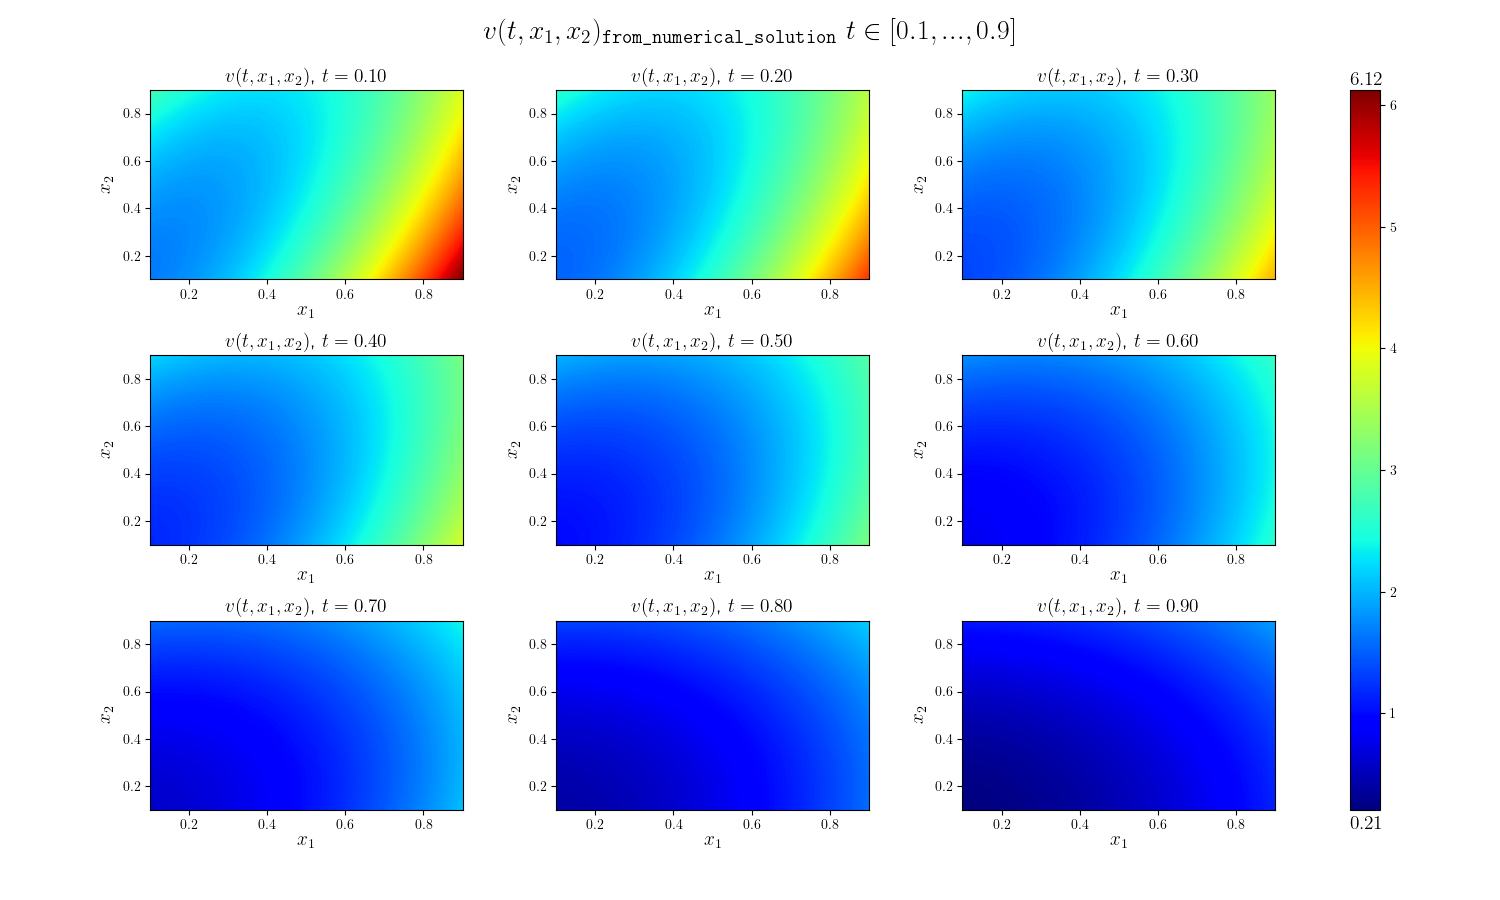

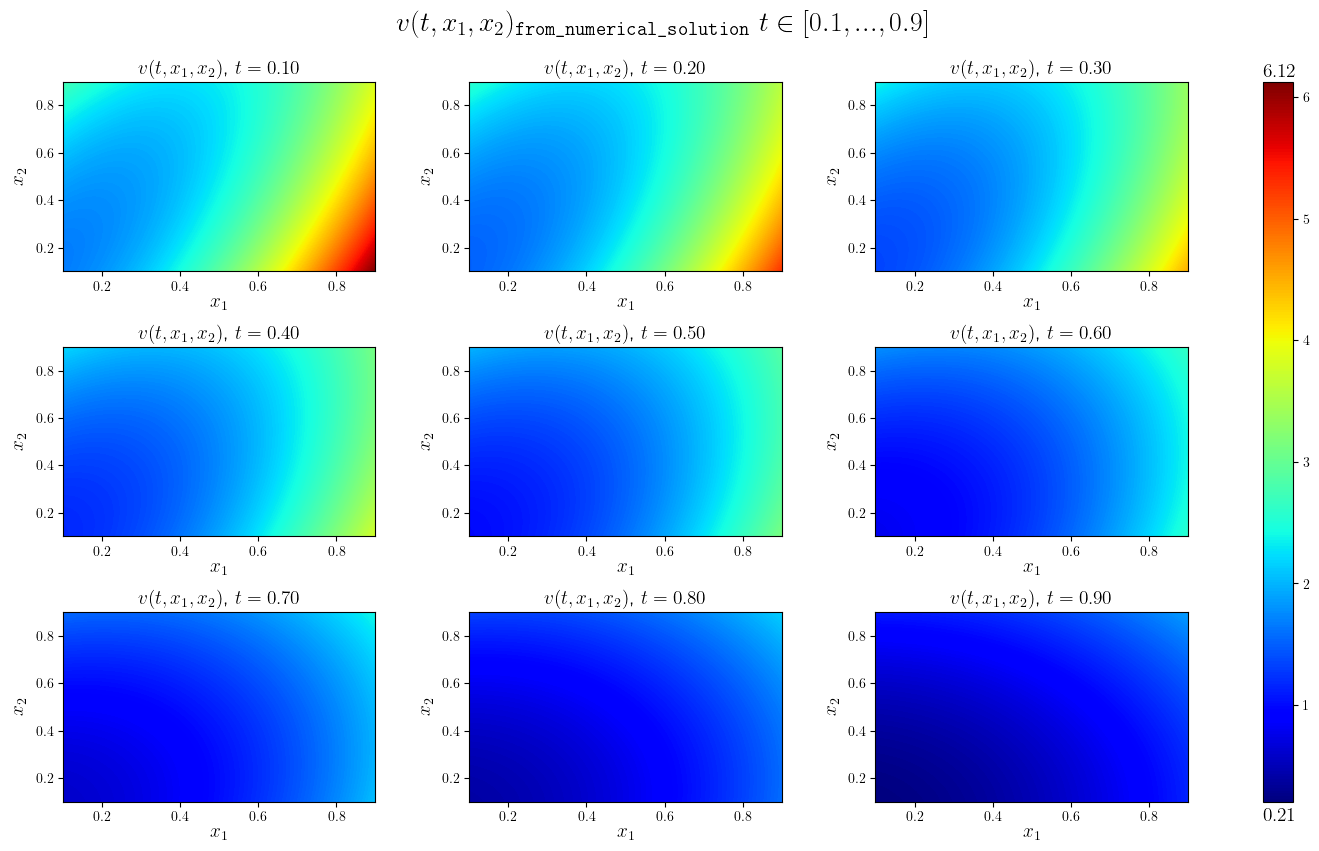

In [76]:
#plot image

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

fig, axs = plt.subplots(3, 3, figsize=(15, 9))
cmap = 'jet'

for i in range(len(t_batch_i)):
        axs[i//3][i%3].contourf(X1.numpy(), X2.numpy(), value_numerical_reshape[i].numpy(),levels=500,cmap=cmap, vmin=value_min, vmax=value_max,linewidths=0)
        axs[i//3][i%3].set_title(fr'$v(t,x_1,x_2)$, $t = {{{t_batch_i[i]:.2f}}}$',fontsize=14)
        axs[i//3][i%3].set_xlabel(r'$x_1$', labelpad=0,fontsize=14)
        axs[i//3][i%3].set_ylabel(r'$x_2$', labelpad=6,fontsize=14)
cbaxes = fig.add_axes([0.90, 0.1, 0.02, 0.8])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=value_min, vmax=value_max), cmap=cmap), cax=cbaxes, orientation='vertical')

cbar_ax_pos = cbar.ax.get_position()

text_x = cbar_ax_pos.x0 
text_y_min = cbar_ax_pos.y0  
text_y_max = cbar_ax_pos.y0 + cbar_ax_pos.height  

fig.text(text_x, text_y_min-0.025, fr'${{{value_min:.2f}}}$', va='bottom', ha='left',fontsize=14)
fig.text(text_x, text_y_max+0.02, fr'${{{value_max:.2f}}}$', va='top', ha='left',fontsize=14)

plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)
fig.suptitle(r'{\rmfamily $v(t,x_1,x_2)_{\Large \texttt{from_numerical_solution}}$  $t \in [0.1,...,0.9]$}',fontsize=20)
plt.show()
display(fig)

plt.savefig('value_from_numerical.eps', format='eps', dpi=600)
plt.savefig('value_from_numerical.png', format='png', dpi=600)